In [1]:
import numpy as np, os
import matplotlib as mpl
%matplotlib notebook

In [2]:
workdir = '_tmp.explore2'
!mkdir -p {workdir}
%cd {workdir}

/home/lj7/dv/mcvine/phonon/tests/phonon/_tmp.explore2


In [3]:
from mcvine.phonon.from_phonopy import call_phonopy

In [4]:
supercell = 6,6,1
sc_mat = np.diag(supercell)

In [5]:
graphite_datadir = os.path.abspath('../../data/graphite/')

In [6]:
from phonopy import file_IO
force_constants=file_IO.parse_FORCE_CONSTANTS(os.path.join(graphite_datadir, 'FORCE_CONSTANTS'))

In [7]:
poscar = os.path.join(graphite_datadir, 'POSCAR')

In [8]:
species = ['C']

In [9]:
qpoints = [[0.,0.,0.]]

In [10]:
qs, freqs, pols = call_phonopy.onGrid(
    species, qpoints, sc_mat, 
    force_constants = force_constants,
    poscar = poscar)

# random

In [57]:
N = 1000000
qpoints = np.random.rand(N, 3)

In [58]:
qpoints.shape

(1000000, 3)

In [59]:
qpoints[:, :2] *= 9
qpoints[:, -1] *= 3

In [94]:
%%time
qs, freqs, pols = call_phonopy.onGrid(
    ['C'], qpoints, sc_mat, 
    force_constants = force_constants,
    poscar = os.path.join(graphite_datadir, 'POSCAR'),
    freq2omega=1
)

CPU times: user 29min 57s, sys: 49min 30s, total: 1h 19min 27s
Wall time: 6min 40s


In [95]:
freqs[freqs<0] = 0

In [96]:
# omega2 = freqs**2 * 1e24 * (2*np.pi)**2

In [97]:
omega = freqs*1e12*2*np.pi

In [98]:
nq, nbr, natoms, three = pols.shape

In [99]:
assert three is 3

In [100]:
from phonopy.interface import vasp
atoms = vasp.read_vasp(poscar, species)
positions = atoms.get_scaled_positions()

In [ ]:
for iatom in range(natoms):
    qdotr = np.dot(qs, positions[iatom]) * 2 * np.pi
    phase = np.exp(-1j * qdotr)
    pols[:, :, iatom, :] *= phase[:, np.newaxis, np.newaxis]
    continue

# Compute

In [102]:
from mcvine.phonon import from_phonopy

In [103]:
from_phonopy.make_crystal_xyz('graphite.xyz', species, poscar)

In [104]:
from sampleassembly.crystal.ioutils import xyzfile2unitcell

In [105]:
uc = xyzfile2unitcell('graphite.xyz')

In [106]:
Q_basis = uc.lattice.recbase * 2 * np.pi

In [107]:
Q_basis

array([[ 2.56856068,  0.        ,  0.        ],
       [ 1.4829592 ,  2.9659184 ,  0.        ],
       [ 0.        ,  0.        ,  0.94423941]])

In [108]:
from mccomponents.sample.idf import units

In [109]:
omega *= units.hertz2mev

In [110]:
omega[0]

array([  40.99725328,   42.7005362 ,   87.11883767,   87.17184155,
         89.26935612,   89.65919296,  134.92585875,  135.4089843 ,
        178.50502972,  178.76930172,  185.83083016,  186.04391575])

In [111]:
omega.shape

(1000000, 12)

In [112]:
pols.shape

(1000000, 12, 4, 3)

In [113]:
nbranches = nbr

In [114]:
Q_bins = np.arange(0,22, 0.1)
E_bins = np.arange(0,250, 1.)
bins = Q_bins, E_bins
# max Q of requested Q axis                                                                                                                                                                                                                                                                                     
max_Q = Q_bins[-1]

In [115]:
%%time
I = 0
for ibr in range(nbranches):
    Q_hkl = qs
    Q_cart = np.dot(Q_hkl, Q_basis)  # nQ, 3   
    Q_mag = np.linalg.norm(Q_cart, axis=-1) # nQ                
    good = Q_mag < max_Q
    Q_mag = Q_mag[good]
    omega0 = omega[good, ibr]
    Q_cart = Q_cart[good]
    #
    exp_Q_dot_d = np.exp(1j * np.dot(Q_cart, positions.T)) # nQ, natoms 
    pols1 = pols[good, ibr, :, :] # nQ, natoms, 3   
    Q_dot_pol = np.sum(np.transpose(pols1, (1,0,2)) * Q_cart, axis=-1).T # nQ, natoms
    # 
    F = np.sum(exp_Q_dot_d * Q_dot_pol, axis=-1) # nQ      
    M = np.abs(F)**2 # nQ       
    I1, Qbb, Ebb = np.histogram2d(Q_mag, omega0, bins=bins, weights=M)
    I = I + I1
    continue

CPU times: user 4.94 s, sys: 288 ms, total: 5.23 s
Wall time: 5.21 s


In [116]:
import histogram as H, histogram.hdf as hh

In [117]:
IQEhist = H.histogram(
    'IQE',
    (H.axis('Q', boundaries=Qbb, unit='1./angstrom'),
     H.axis('E', boundaries=Ebb, unit='meV')),
    data=I)

plot z in (0.0, 26362.0062069)


<IPython.core.display.Javascript object>


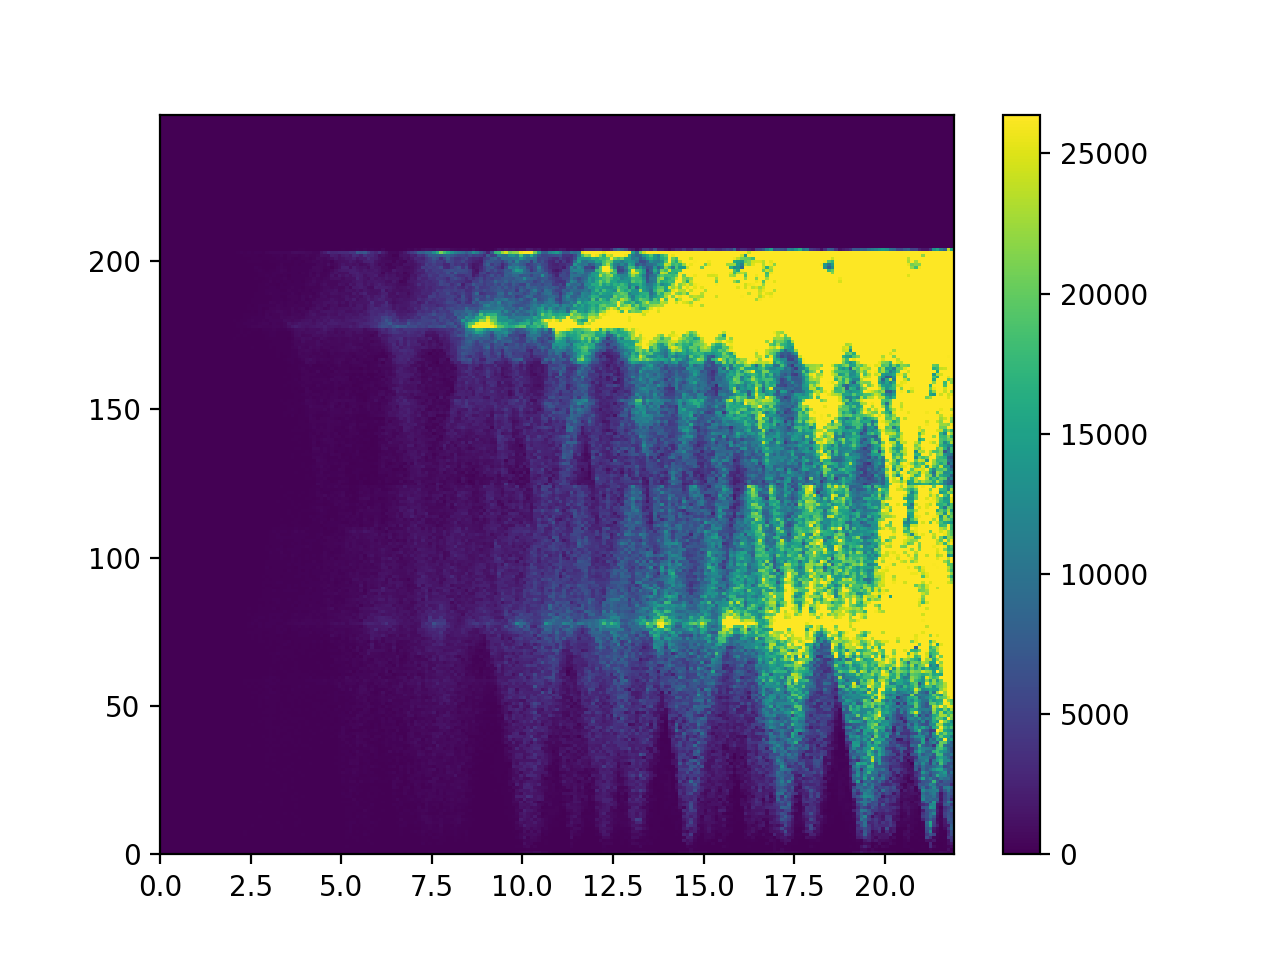

In [84]:
H.plot(IQEhist)

# Try DW fractor

In [86]:
Qcenters = (Qbb[1:] + Qbb[:-1])/2

In [92]:
IQEhist = H.histogram(
    'IQE',
    (H.axis('Q', boundaries=Qbb, unit='1./angstrom'),
     H.axis('E', boundaries=Ebb, unit='meV')),
    data=I*(np.exp(-Qcenters * Qcenters * 0.005)[:, np.newaxis]))

plot z in (0.0, 12449.9462316)


<IPython.core.display.Javascript object>


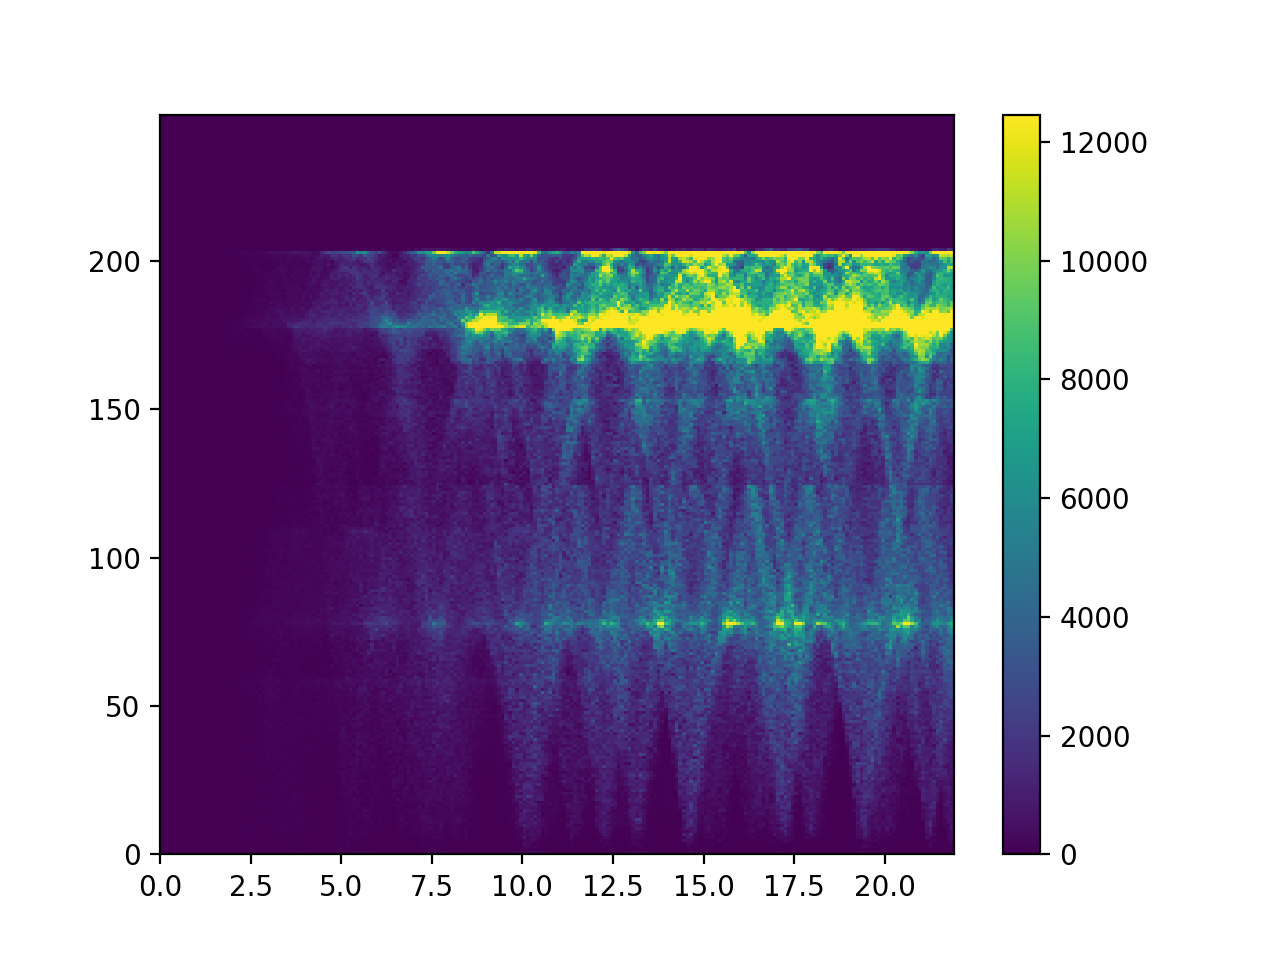

In [93]:
H.plot(IQEhist)